# Time Series 


### Basic

시간에 따른 stochastic variables 로 이루어진 데이터를 Time series data라고 하며, <br>
정수값 $ t $ 로 인덱스되며 **동일한 시간 격차(equal-spaced time intervals)**을 갖고 있는 것을 시계열 데이터라고 합니다.<br>
단 한개의 변수로 이루어진 time series를 **univariate** 이라고 하며, 2개 이상의 변수로 이루어진 time series를 **multivariate**이라고 합니다.


### Trend, Cyclical, Seasonal, Irregular 

Time series는 일반적으로 4개의 요소 (Trend, Cyclical, Seasonal 그리고 Irregular)에 의해 영향을 받습니다.

| Name | Description |
|:-----|:------------|
| **Trend(추세)** |  장기적인 관점에서 봤을때 그래프가 증가하는지, 감소하는지, 또는 정체되어 있는지등의 추세를 Trend라고 합니다.<br>Trend는 따라서 time series안에서 long term movement를 보는 것이 중요합니다. |
| **Seasonality(계절성)** | 특정 구간동안의 (1년, 한달, 일주일..) 변동성(fluctuations)를 나타냅니다. <br>예를 들어서 아이스크림 판매량은 여름에 늘어나고, 외투는 겨운에 판매량이 늘어날 것입니다. 또는 피트니스센터의 고객은 매년 결심을 하는 1월 초에 가장많은 사람들이 나올것입니다. 하지만 매월초가 될수도 있고, 매주초가 될 수도 있습니다. 따라서 피트니스센터는 년, 월, 주단위 seasonality를 갖고 있다고 할수 있습니다. |
| **Cycle(주기)** | Seasonality는 특정 기간에 정확하게 나타나는 변동성을 갖고 있는 반면, Cycle의 경우 특정 시간에 구애 받지 않습니다. 하지만 동일하게 특정 패턴을 갖고 있습니다. 보통 2~3년처럼 장기간에 걸친 패턴을 갖고 있을수 있습니다. 예를 들어서 business cycle의 경우에는 호황 -> 불황 -> 침체 -> 회복 의 cycle을 갖고 있습니다. | 
| **Irregularity(불규칙성)** | 또는 random variations이라고 불리며 예상치 못한 영향에 의해서 나타납니다. 예를 들어서 전쟁, 지진, 홍수, 혁명등등이 될 수 있습니다. |



### Stationary Time Series

다음과 같은 조건을 갖으면 Stationary Time Series라고 할 수 있습니다. 

**모든 $ t $에 관하여 일정한 평균**<br>
$ E(x_t) = \mu $

**모든 $ t $에 관하여 일정한 분산**<br>
$ E[(x_t - \mu)^2] = Var(x_t) = \sigma^2 = \gamma(0)  $

**covariance는 t가 아닌 s에 의존**<br>
$ cov(y_t, t_{t+s}) = cov(y_t, y_{t-s}) = \gamma_s $

즉 평균과 분산이 각각 상수를 갖고 있으며, 시간이 지나도 평균과 분산이 변하지 않는다는 뜻입니다. <br>

# Import

In [1]:
%pylab inline
import math
import pandas as pd
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels import api as sm

from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data

아래의 링크에서 데이터를 다운받을 수 있습니다.<br>
[Daily minimum temperatures in Melbourne, Australia, 1981-1990](https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line)

[Header]
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Train Size: (3600, 1)
Test Size : (50, 1)


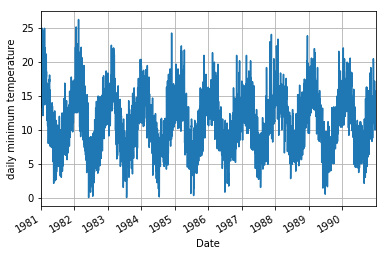

In [2]:
TEST_SIZE = 50

_filename= '/dataset/daily-minimum-temperature-in-melbourne/daily-minimum-temperatures-in-me.csv'
dataframe = pd.Series.from_csv(_filename, header=0)
dataframe.index = dataframe.index.to_datetime()
dataframe = dataframe.astype('float64')
print('[Header]')
print(dataframe.head())
dataframe.plot(grid=True)
ylabel('daily minimum temperature')

# Normalization 
scaler = MinMaxScaler()
data = scaler.fit_transform(dataframe.values.reshape((-1, 1)))

# Split Training and Test Data
train, test = data[:-TEST_SIZE], data[-TEST_SIZE:]
# train, test = train_test_split(data, test_size=0.1)
# train_data, test_data = data[0:len(data)-7], data[len(data)-7:]
print()
print('Train Size:', train.shape)
print('Test Size :', test.shape)

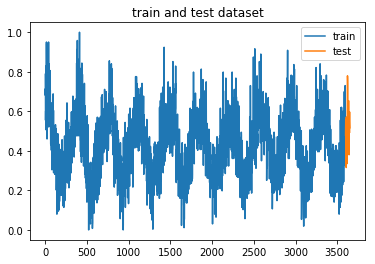

In [3]:
plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

            passenger
1949-01-01      112.0
1949-02-01      118.0
1949-03-01      132.0
1949-04-01      129.0
1949-05-01      121.0


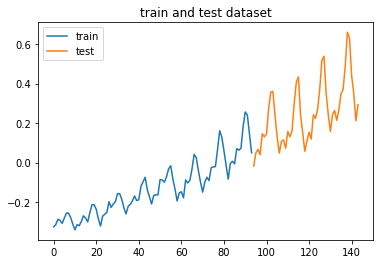

In [151]:
TEST_SIZE = 50

dataframe = pd.read_csv('/dataset/time-series/international-airline-passengers/international-airline-passengers.csv', 
                   names=[ 'passenger'], index_col=0,
                   skiprows=1)
dataframe.index = pd.to_datetime(dataframe.index)
dataframe = dataframe.astype('float64')
print(dataframe.head())

scaler = MinMaxScaler()
data = scaler.fit_transform(dataframe.values.reshape((-1, 1)))

# Mean Adjusted Time Series
mu = np.mean(data)
data_adjusted = data - mu

train, test = data_adjusted[:-TEST_SIZE], data_adjusted[-TEST_SIZE:]

plot(np.arange(len(train)), train, label='train')
plot(np.arange(len(train), len(train)+len(test)), test, label='test')
legend()
title('train and test dataset')

In [164]:
LAG = 12
def to_timeseries(data, lag):
    data = data.reshape(-1)
    N = len(data[LAG:])
    ts = list()
    
    for i in range(N):
        ts.append(data[i:i+LAG].tolist())
    ts = np.array(ts)
    return ts
    
ts_data = to_timeseries(data_adjusted, lag=LAG)
ts_train, ts_test = ts_data[:-TEST_SIZE], ts_data[-TEST_SIZE:]

print('ts_train:', ts_train.shape)
print('ts_test :', ts_test.shape)

ts_train: (82, 12)
ts_test : (50, 12)


# Autocorrelation Checking

Autoregression은 이전의 time-steps의 observations을 통해 다음 step의 값을 예측하는데 사용될 수 있다는 가정을 갖고 있습니다.<br>
variables관의 관계를 correlation이라고 하며, 두 variables이 동시에 증가하거나 감소하면 **positive correlation**이라고 하며, 서로 반대방향으로 움직인다면 (하나는 증가하고, 하나는 감소하는 상황.) **negative correlation**이라고 합니다.

output variable (예측값) 그리고 이전 time-steps의 값(lagged variables)들의 correlation을 구함으로서 통계적 측정을 할 수 있습니다.<br>
correlation을 통해서 얼마만큼의 lag variables을 사용해야될지 알 수 있으며, 그래프가 predictable한지 안 한지도 알 수 있습니다.

> Autocorrelation에서 auto가 붙는 이유는 위에서 설명했듯이, 자기자신(auto or self)의 데이터를 사용하여 자기 자신의 데이터를 예측하기 때문에 이렇게 이름이 지어졌습니다.



### Lag Plot 

빠르게 correlation이 존재하는지 확인하는 방법은 step t 와 t-1 을 scatter plot으로 그래서 확인하는 방법입니다.<br>
집접 데이터를 가공해서 만들수도 있지만, Pandas에서는 lag_plot이라는 함수를 통해서 쉽게 lag plot을 그려볼 수 있습니다.


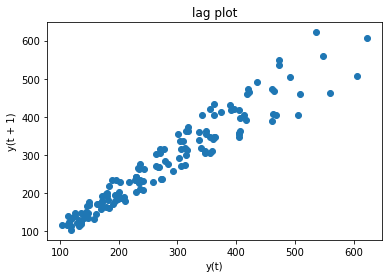

In [6]:
lag_plot(dataframe, lag=1)
title('lag plot')

step t 와 step t-1 의 관계가 전혀 없는 random한 상황속에서는 다음과 같이 그래프가 그려집니다.

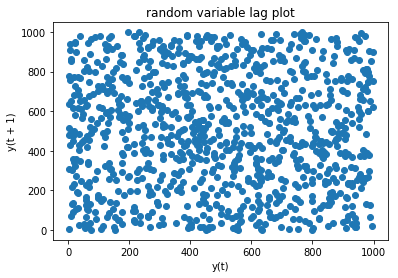

In [7]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
lag_plot(series)
title('random variable lag plot')

### Pearson Correlation Coefficient

t-1 과 t의 상관관계를 pearson correlation으로 구할수 있습니다. <br>

* negative correlated: -1 
* positive correlated: 1
* correlation: 0.5보다 크거나, -0.5보다 작을시 높은 correlation

아래의 예제에서는 0.77487의 correlation값을 보이는데 positive correlated이며 correlation이 높다고 할 수 있습니다.

In [8]:
data2 = pd.concat([dataframe.shift(2), dataframe.shift(1), dataframe], axis=1)
data2.columns = ['t-2', 't-1', 't']
data2.corr()

,t-2,t-1,t
t-2,1.000000,0.960249,0.895675
t-1,0.960249,1.000000,0.960195
t,0.895675,0.960195,1.000000


### Autocorrelation Plot

각각의 lag variable에 대한 correlation을 plotting할 수 도 있지만, Pandas에서 이미 지원해주고 있습니다.

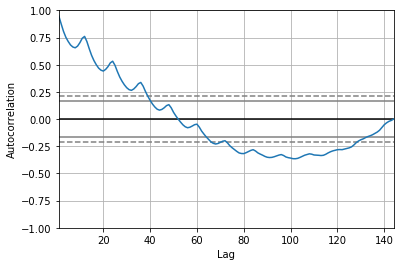

In [9]:
autocorrelation_plot(data)

statsmodel 라이브러리에서 제공하는 plot_acf를 사용할수도 있습니다.

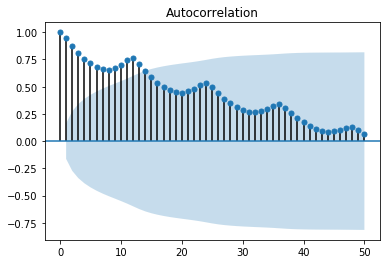

In [10]:
plot_acf(data, lags=50)
print(end='')

Random variable의 경우에는 다음과 같이 전혀 맞지 않게 나옵니다.

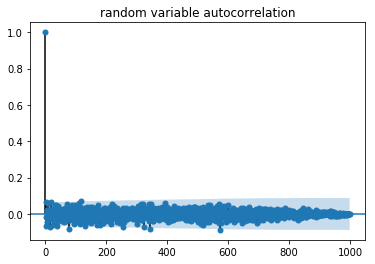

In [11]:
series = pd.Series([np.random.randint(0, 1000) for _ in range(1000)])
plot_acf(series, title='random variable autocorrelation')
print()

# Lag Operator

Lag Operator $ L $ 또는 Backshift $ B $ 로 표현을 하며 시계열상의 과거의 데이터를 설명할때 사용합니다.

$$ \begin{align} 
Ly_t &= y_{t-1} \\
y_t &= Ly_{t+1} \\
\end{align} $$

이때 Lag Operator $ L $ 은 여러가지 정수값으로 제곱이 될 수 있습니다.

$$ \begin{align} 
L^ky_t &= y_{t-k} \\
L^{-1}y_t &= y_{t+1} \\
L^2y_t &= y_{t-2} \\
\end{align}$$

### Lag Polynomials

$ a(L) $ 를 lag polynomials 로 정의한다면 다음과 같습니다.

$$ a(L) = a_0 + a_1L + ... + a_pL^p $$

위의 공식은 operator로서 사용이 될 수 있습니다.

$$ a(L)x_t = a_0x_t + a_1x_{t-1} + .. + a_p x_{t-p} $$

lag polynomials는 더하거나 곱하는 연산을 할 수도 있습니다. <br>
예를 들어서 만약 $ a(L) = (1-aL) $ 이고 $ b(L) = (1-bL) $ 이라면 

$$ \begin{align} 
a(L)b(L)x_t &=  (1-aL)(1-bL)x_t \\
  &= (1-aL)(x_t - bx_{t-1}) \\
  &= x_t - bx_{t-1} - aL(x_t - bx_{t-1}) \\
  &= x_t - bx_{t-1} - a(x_{t-1} - bx_{t-2}) \\
  &= x_t - bx_{t-1} - ax_{t-1} + abx_{t-2} \\
  &= x_t -(a+b)x_{t-1} + abx_{t-2} \\
  &= \left( 1 - (a+b)L + abL^2 \right) x_t
\end{align} $$

### Invert 

lag polymials 는 inverted될 수 있습니다. 

$$ (1-pL)(1-pL)^{-1} = \frac{(1-pL)}{(1-pL)} = 1 $$


### Difference Operator 

Time series 분석에서 first difference operator $ \Delta $ 는 lag polynomial의 특별한 케이스입니다.

$$ \begin{align} 
\Delta X_t &= X_t - X_{t-1} \\
\Delta X_t &= (1 - L)X_t \\
\end{align} $$

유사하게 second difference operator는 다음과 같습니다.

$$ \begin{align} 
\Delta(\Delta X_t) &= \Delta X_t - \Delta X_{t-1} \\
  \Delta^2 X_t &= (1 - L) \Delta X_t \\
  \Delta^2 X_t &= (1-L)(1-L) X_t \\
  \Delta^2 X_t &= (1-L)^2 X_t
\end{align} $$

위의 공식은 다음과 같이 일반화 될 수 있습니다.

$$ \Delta^i X_i = (1-L)^i X_t $$

Seconds Difference의 예제는 다음과 같습니다.

| Original Sequence | 0  |    | 1  |    | 4  |    | 9  |    | 16 |    | 25 |    | 36 |
|:------------------|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| First Difference  |    | 1  |    | 3  |    | 5  |    | 7  |    | 9  |    | 11 |    |
| Second Difference |    |    | 2  |    | 2  |    | 2  |    | 2  |    | 2  |    |&nbsp;|


# AR (Autoregressive) Model

AR(p) (AutoRegressive of order p)는 간단하게 과거의 패턴이 지속된다면 <br>
시계열 데이터 관측치 $ y_t $ 는 과거 관측치 $ y_{t-1} $, $ y_{t-2} $, $ y_{t-3} $, ... 에 의해 예측될 수 있다고 봅니다. <br>
오직 과거의 데이터(lagged variables)만 사용해서 예측 모형을 만들게 되며, 이름도 autoregressive 입니다. (그리스어로 auto 라는 뜻은 "self"를 가르킵니다.)<br>



$$ \begin{align}
X_t &= \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + c  \\
&= c + \sum^p_{i=1} \alpha_i X_{t-i} + \epsilon_t
\end{align}$$ 

* **order:** $ p $ 는 모델에서 사용된 lagged variables의 갯수
* **parameters (coefficients):** $ \alpha_1 $, $ \alpha_2 $, ..., $ \alpha_p $
* **error term (white noise):** $ \epsilon_t $

즉 time lag operator를 사용하면 다음과 같이 공식을 세울 수 있습니다.<br>
그리고 아래의 notation은 ARMA (autoregressive moving average)와 동일합니다.

$$ \left( 1 - \sum^p_{k=1} \alpha_k L^k \right) X_t = \epsilon_t $$

이때 다음과 같은 조건들을 갖습니다.

$$ \begin{align} 
|\alpha| &< 1 \\
Var[X_t] &= \frac{\sigma^2}{1-\sigma^2}
\end{align} $$

예를 들어서 order $ p $ 값이 2인 AR(2) 를 구하면 다음과 같습니다.

$$ x_t = \alpha_1 x_{t-1} + \alpha_2 x_{t-2} + \epsilon_t  $$


> <span style="color:red;"> AR은 일반적으로 t+7 정도밖에 예측을 못합니다. <br>
> 데이터에 따라서 다르지만, 실전에 들어가면 워낙 랜덤한 부분이 많아서 제대로 예측을 못합니다.

## Code in statsmodels

Params: [ 0.0555362   0.48485522 -0.25494785  0.182324   -0.20208175  0.20946825
 -0.12631762  0.09739854 -0.19255776  0.20917163 -0.20369166  0.34405421
  0.55972614]
Lag: 12
Train R^2: 0.972219871151
Train MSE: 0.00353950169491
Test  R^2: 0.491448579238
Test  MSE: 0.0194934655048


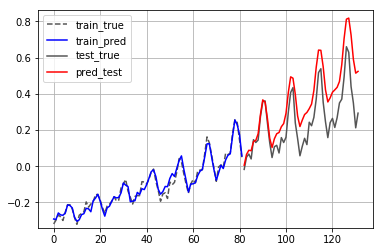

In [12]:
PRED_N = 300
model_ar = AR(train)
model_ar = model_ar.fit(disp=True)

pred_train = model_ar.predict(start=model_ar.k_ar, end=len(train)-1)
pred_test = model_ar.predict(start=len(train), end=len(train)+len(test)-1)
    
def show_result(train, test, train_pred, test_pred, lag):
    x_train = np.arange(len(train_pred))
    x_test = np.arange(len(train_pred), len(train_pred) + len(test_pred))
    
    ylim(np.min(train), np.max(test) + np.std(test)*1.3)
    plot(x_train, train[lag:], linestyle="--", label='train_true', color="#555555")
    plot(x_train, train_pred, label='train_pred', color='blue')
    plot(x_test, test, label='test_true',  color='#555555')
    plot(x_test, test_pred, label='pred_test', color='red')
    legend()
    grid()
        
    print('Lag:', lag)
    print('Train R^2:', r2_score(train_pred, train[lag:]))
    print('Train MSE:', mean_squared_error(train_pred, train[:-lag]))
    print('Test  R^2:', r2_score(test_pred, test))
    print('Test  MSE:', mean_squared_error(test_pred, test))

print('Params:', model_ar.params)
show_result(train, test, pred_train, pred_test, lag=model_ar.k_ar)

## Using Leastsquare


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     157.7
Date:                Tue, 08 Aug 2017   Prob (F-statistic):           1.13e-44
Time:                        17:46:42   Log-Likelihood:                 186.75
No. Observations:                  81   AIC:                            -347.5
Df Residuals:                      68   BIC:                            -316.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0654      0.007      8.853      0.000       0.051       0.080
x1            -0.2334      0.135     -1.723      0.089      -0.504       0.037
x2             1.1235      0.145      7.759      0.000       0.835       1.413
x3             0.0424      0.141      0.300      0.765      -0.240       0.325
x4             0.0441      0.136      0.324      0.747      -0.228       0.316
x5            -0.0295      0.135     -0.218      0.828      -0.299       0.240
x6            -0.0067      0.136     -0.049      0.961      -0.279       0.266
x7            -0.0773      0.136     -0.568      0.572      -0.349       0.194
x8             0.0986      0.134      0.736      0.464      -0.169       0.366
x9            -0.0521      0.132     -0.394      0.695      -0.316       0.212
x10            0.0649      0.133      0.488      0.627      -0.201       0.330
x11           -0.1361      0.132     -1.029      0.307      -0.400       0.128
x12            0.2821      0.120      2.357      0.021       0.043       0.521
==============================================================================
Omnibus:                        2.969   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                2.223
Skew:                          -0.339   Prob(JB):                        0.329
Kurtosis:                       3.445   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Lag: 12
Train R^2: 0.853764985702
Train MSE: 0.00560402953505
Test  R^2: -0.18177910966
Test  MSE: 0.0561336321797


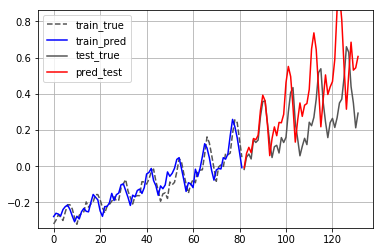

In [183]:
ols = sm.OLS(train[LAG+1:], sm.add_constant(ts_train)[:-1], )
ols = ols.fit()
display(ols.summary())

def predict_with_ols(ols, x, length):
    h = np.ones(x.shape[0] + 1)
    h[1:] = x
    
    response = list()
    for _ in range(length):
        p = ols.predict(h)
        h[1:-1] = h[2:]
        h[-1] = p
        response.append(p)
    response = np.array(response)
    return response

train_pred = ols.predict(sm.add_constant(ts_train))
test_pred = predict_with_ols(ols, ts_train[-1], length=len(test))

show_result(train, test, train_pred, test_pred, lag=LAG)

## Using Polynomial Curve Fitting

과거 12개 데이터를 통해서 그 다음을 예측합니다.

POLY: [ 1.14122357  0.07850594]
Lag: 12
Train R^2: 0.959204626599
Train MSE: 0.00333113179569
Test  R^2: 0.627872323225
Test  MSE: 0.0136219510639


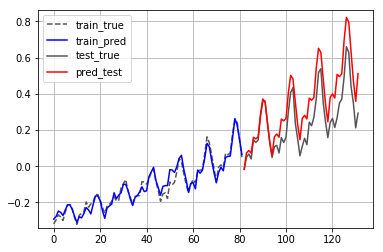

In [15]:
LAG = 12
DEGREE = 1

def poly_pred(poly, x, lag, length):
    h = x
    result = list()
    
    for _ in range(math.ceil(length/lag)):
        h = np.polyval(poly, h)
        result += h.reshape(-1).tolist()
        
    result = np.array(result[:length])
    return result

poly = np.polyfit(train[:-LAG].reshape(-1), train[LAG:].reshape(-1), DEGREE)
train_pred = np.polyval(poly, train[:-LAG])
test_pred = poly_pred(poly, train[-LAG:], lag=LAG, length=len(test)) # np.polyval(poly, train[-LAG:])

print('POLY:', poly)
show_result(train, test, train_pred, test_pred, lag=LAG)

# Moving Average Model

* [PennState STAT 510 - Moving Average Models(MA Models)](https://onlinecourses.science.psu.edu/stat510/node/48)

* [Numpy Cookbook 참고](https://books.google.co.kr/books?id=zWHCCAAAQBAJ&pg=PA222&lpg=PA222&dq=numpy+%22moving+average+model%22&source=bl&ots=VWJa0wmEaP&sig=l_pgyToRagDVGnHA_UUo5DO0Ofg&hl=en&sa=X&ved=0ahUKEwig--Ppw4_VAhWIUrwKHWShDQoQ6AEIOTAE#v=onepage&q=numpy%20%22moving%20average%20model%22&f=false)

Moving-average Model MA(q)는 AR(p)와 매우 유사하며 마찬가지로 univariate time series를 모델링 하는데 사용되는 방법중의 하나입니다. <br>
두 모델의 차이점은 MA(q) 모델의 경우 과거의 white noise error를 사용합니다. <br>
<span style="color:red">즉 AR(p)의 경우 과거 p값 만큼의 과거의 lagged variables사용해서 예측을 하는 반면, <br>
MA(q) 모델은 과거의 예측 에러(forecast errors)에서 나온 값을 사용해서 예측을 합니다.</span>

AR Model과 함께 ARMA 그리고 ARIMA 모델의 중요 컴포넌트가 됩니다.<br> 

> Moving Average Model은 Moving Average와 전혀 다릅니다.

### Definition

MA(q) 모델은 noise에 관하여 $ X_t $에 대해 다음과 같이 정의를 하고 있습니다.

$$ X_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} $$

$ \epsilon $ 기호는 error (white noise)로 읽으면 됩니다. (epsilon이 아니라..) <br>
noise 의 (weighted)평균으로 구해지지만 전체 시간을 모두 구하는 것이 아니라, average moving $ t $ 그리고 $ q+1 $ times가 사용됩니다.<br>
time lags를 사용하여 다음과 같이 정의 할 수 있습니다.

$$ X_t = c+ \left(1 + \sum^q_{k=1} \beta_k L^k \right) \epsilon_t $$

## 

## Code


In [16]:
from scipy.optimize import leastsq
from statsmodels.regression.linear_model import GLS

class MA(object):
    def __init__(self, lag=5):
        self.lag = lag
        self.w = np.random.rand(lag)
        print(self.w)
        
    def fit(self, x):
        mean = x.mean()
        a, b = leastsq(self.error, self.w, args=(x-mean,) )
        
        gls = GLS(x[1:], x[:-1]).fit()
        print(gls.params)
        return gls
        
        
    def error(self, w, x):
        return w * x[:self.lag].reshape(-1)
        
ma = MA()
gls = ma.fit(train)



[ 0.39053086  0.14394603  0.87186933  0.95085476  0.75024704]
[ 0.9579881]


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   94
Model:                     ARMA(4, 2)   Log Likelihood                 172.898
Method:                       css-mle   S.D. of innovations              0.037
Date:                Tue, 08 Aug 2017   AIC                           -329.796
Time:                        17:08:11   BIC                           -309.449
Sample:                             0   HQIC                          -321.577
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1286      0.083     -1.545      0.126      -0.292       0.034
ar.L1.y        1.9170      0.120     15.967      0.000       1.682       2.152
ar.L2.y       -1.9104      0.229     -8.327      0.0

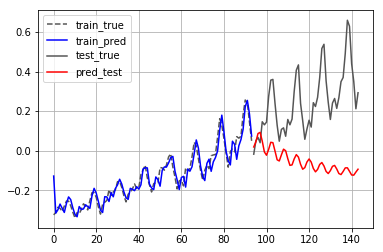

In [17]:
model_arma = ARMA(train, order=(4, 2, 1))
model_arma = model_arma.fit(max_lag=30)
print(model_arma.summary())

pred_train = model_arma.predict(0)
pred_test = model_arma.predict(start=len(train), end=len(train) + len(test)-1)

x_train = np.arange(len(pred_train))
x_test = np.arange(len(pred_train), len(pred_train) + len(pred_test))

plot(x_train, train, linestyle="--", label='train_true', color="#555555")
plot(x_train, pred_train, label='train_pred', color='blue')
plot(x_test, test, label='test_true',  color='#555555')
plot(x_test, pred_test, label='pred_test', color='red')
legend()
grid()

print('Lag:', model_ar.k_ar)
print('Params:', model_ar.params.shape)
print('Train R^2:', r2_score(pred_train, train))
print('Train MSE:', mean_squared_error(pred_train, train))
print('Test  R^2:', r2_score(pred_test, test))
print('Test  MSE:', mean_squared_error(pred_test, test))

# ARMA (AutoRegressive Moving Average) Model

ARMA(p, q) (AutoRegressive Moving Average with orders p and q) 는 AR(p) 와 MA(q) 를 합친 모델이며, univariate time series 모델링에 적합합니다.<br>
미래의 값은.. 과거 p 관측치 그리고 random error를 합친 것으로 여깁니다.

* AR(p) 모델은 momentum 그리고 주식시장에서 주로 나타나는.. mean reversion effect 를 설명합니다.
* MA(q) 모델은 white noise에서 관측되는 shock effects 를 설명합니다. <br>shock effects는 예상치못한 이벤트로 설명될수 있습니다. 예를 들어서 서프라이즈 어닝 또는 테러공격등등..


$$ \left( 1 - \sum^p_{k=1} \alpha_k L^k \right) X_t = \left( 1 + \sum^q_{k=1} \beta_k L^k \right) \epsilon_t $$

풀어쓰면 다음과 같습니다.

$$ X_t = \alpha_1 X_{t-1} + ... + \alpha_p X_{t-p} + \epsilon_t + \beta_1 \epsilon_{t-1} + ... + \beta_q \epsilon_{t-q} $$

### ARMA 코드 구현

Python from statsmodels.tsa.arima_model 안의 ARMA 를 사용해서 구현할수 있습니다. <br>
사용되는 공식은 다음과 같습니다.

![alt text](images/arma.jpg " jaja")



In [18]:
arma = ARMA(train, (29, 5))
arma.endog

array([-0.32490079, -0.31331778, -0.28629076, -0.29208226, -0.30752628,
       -0.28049925, -0.25540272, -0.25540272, -0.27856875, -0.31138728,
       -0.34034481, -0.31331778, -0.31910929, -0.29787377, -0.26891624,
       -0.28049925, -0.29980427, -0.25347222, -0.21293168, -0.21293168,
       -0.2360977 , -0.28436025, -0.32103979, -0.27084674, -0.26119423,
       -0.25154172, -0.19748767, -0.2264452 , -0.20907068, -0.19748767,
       -0.15694713, -0.15694713, -0.18590465, -0.2283757 , -0.25926373,
       -0.22065369, -0.21100118, -0.19362666, -0.16853014, -0.19169616,
       -0.18783516, -0.12026759, -0.09710157, -0.07393554, -0.13764211,
       -0.17239114, -0.20907068, -0.16659964, -0.16273863, -0.16273863,
       -0.08551855, -0.08744906, -0.09903207, -0.07200504, -0.0314645 ,
       -0.01602048, -0.08358805, -0.1337811 , -0.19362666, -0.15308612,
       -0.14729462, -0.17818265, -0.08744906, -0.10289307, -0.08937956,
       -0.0314645 ,  0.04189457,  0.02452006, -0.04111701, -0.09

# Auto-Regressive Integrated Moving Average (ARIMA)

ARIMA를 적용하기 위해서는 time series는 linear 하며 통계적 분포(normal distribution같은 statistical distribution)을 따른다고 가정합니다. <br>
다음의 모델들의 특징을 모두 갖고 있습니다.

* Autoregressive (AR)
* Moving Average (MA)

# References 

* https://gejza.nipax.cz/_media/stochasticke_procesy:1302.6613.pdf
* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#MA
* http://www.uh.edu/~bsorense/arma-intro2012.pdf
* http://users.dma.unipi.it/~flandoli/AUTCap4.pdf
* https://en.wikipedia.org/wiki/Lag_operator
* http://homepage.stat.uiowa.edu/~rdecook/stat2020/notes/ch5_pt1.pdf
* http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016